In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()   # choose your 3 CSV files (Costing Data.csv, Sales Data.csv, Marketing and Competition Data.csv)
for fn in uploaded:
    print("Uploaded:", fn)


In [ ]:
import pandas as pd, os, glob
import numpy as np

# Adjust these if you mounted drive - set out_dir to a folder in your Drive for persistence
OUT_DIR = "/content/drive/MyDrive/Harrys/Data_Processed/Clean_File"  # recommended
LOCAL_TMP = "/content"  # where files sit if uploaded via files.upload()

os.makedirs(OUT_DIR, exist_ok=True)

def find_file(patterns):
    # search /content first, then Drive upload folder if you used it
    for p in patterns:
        p1 = os.path.join(LOCAL_TMP, p)
        if os.path.exists(p1):
            return p1
        p2 = os.path.join("/content/drive/MyDrive/Harrys/Data_Raw", p)
        if os.path.exists(p2):
            return p2
    # fallback: try glob for similar names
    for path in glob.glob("/content/*"):
        name = os.path.basename(path).lower()
        for pat in patterns:
            if pat.replace(" ", "").lower() in name.replace(" ", ""):
                return path
    return None

def parse_month(col):
    col = pd.to_datetime(col, format="%b-%y", errors="coerce")
    if col.isna().all():
        col = pd.to_datetime(col, errors="coerce")
    return col

def clean_numeric(series):
    s = series.astype(str).str.replace(r"[€,]", "", regex=True).str.replace(r"\s+", "", regex=True)
    s = s.replace({"nan": np.nan, "None": np.nan, "": np.nan})
    return pd.to_numeric(s, errors="coerce")

# 1) Sales
sales_path = find_file(["Sales Data.csv","sales_data.csv","sales.csv"])
if sales_path:
    # Added sep='|' to correctly parse the sales data
    sales = pd.read_csv(sales_path, sep='|')
    sales.columns = [c.strip() for c in sales.columns]
    if "Month" in sales.columns:
        sales["Month"] = parse_month(sales["Month"])
    for col in ["Units Sold", "Revenue (€)"]: # Corrected Revenue column name
        if col in sales.columns:
            sales[col] = clean_numeric(sales[col])
    out = os.path.join(OUT_DIR, "sales_data_clean.csv")
    sales.to_csv(out, index=False)
    print("Saved cleaned sales:", out)
else:
    print("Sales file not found. Make sure you uploaded or placed it in Drive Data_Raw.")

# 2) Costing
cost_path = find_file(["Costing Data.csv","costing_data.csv","cost.csv"])
if cost_path:
    costing = pd.read_csv(cost_path)
    costing.columns = [c.strip() for c in costing.columns]
    if "Month" in costing.columns:
        costing["Month"] = parse_month(costing["Month"])
    for col in ["Raw Material Cost (€)", "Labor Cost (€)", "Packaging (€)", "Distribution (€)", "Total Cost (€)"]:
        if col in costing.columns:
            costing[col] = clean_numeric(costing[col])
    out = os.path.join(OUT_DIR, "costing_data_clean.csv")
    costing.to_csv(out, index=False)
    print("Saved cleaned costing:", out)
else:
    print("Costing file not found.")

# 3) Marketing & Competition
mkt_path = find_file([
    "Marketing and Competition Data.csv",
    "marketing_and_competition_data.csv",
    "marketing.csv",
    "Marketing & Competition Data.csv"   # <-- added this line
])
if mkt_path:
    mkt = pd.read_csv(mkt_path)
    mkt.columns = [c.strip() for c in mkt.columns]
    if "Month" in mkt.columns:
        mkt["Month"] = parse_month(mkt["Month"])
    for col in ["Marketing Spend (€)", "Competitor Units Sold", "Competitor Revenue", "Market Share (%)", "Spend (€)"]:
        if col in mkt.columns:
            mkt[col] = clean_numeric(mkt[col])
    out = os.path.join(OUT_DIR, "marketing_data_clean.csv")
    mkt.to_csv(out, index=False)
    print("Saved cleaned marketing:", out)
else:
    print("Marketing file not found.")

Saved cleaned sales: /content/drive/MyDrive/Harrys/Data_Processed/Clean_File/sales_data_clean.csv
Saved cleaned costing: /content/drive/MyDrive/Harrys/Data_Processed/Clean_File/costing_data_clean.csv
Saved cleaned marketing: /content/drive/MyDrive/Harrys/Data_Processed/Clean_File/marketing_data_clean.csv


In [ ]:
# quick validation checks
import pandas as pd, os
out = "/content/drive/MyDrive/Harrys/Data_Processed/Clean_File"
for fn in ["sales_data_clean.csv","costing_data_clean.csv","marketing_data_clean.csv"]:
    p = os.path.join(out, fn)
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"\n{fn}: rows={len(df)}, cols={len(df.columns)}")
        print(df.isnull().sum())
    else:
        print(f"\nMissing: {fn}")


In [ ]:
from google.colab import files
# Example: download sales file from /content
processed = "/content/sales_data_clean.csv"  # change if you used OUT_DIR
if os.path.exists(processed):
    files.download(processed)
else:
    print("No local processed file to download. Use Drive method for persistence.")


In [ ]:
import pandas as pd
import os

# Input folder
IN_DIR = "/content/drive/MyDrive/Harrys/Data_Processed/Clean_File"

def validate_file(file_name, checks):
    path = os.path.join(IN_DIR, file_name)
    if not os.path.exists(path):
        print(f"⚠️ File missing: {file_name}")
        return
    df = pd.read_csv(path)
    print(f"\n🔍 Validating {file_name}: {df.shape[0]} rows, {df.shape[1]} cols")

    # Apply checks
    for desc, func in checks:
        try:
            issues = func(df)
            if len(issues) > 0:
                print(f"❌ {desc}: {len(issues)} issues")
                print(issues.head(3))  # show sample
            else:
                print(f"✅ {desc}: OK")
        except Exception as e:
            print(f"⚠️ {desc} check failed: {e}")

# --- Define Checks ---

def check_missing(df):
    return df[df.isna().any(axis=1)]

def check_negative_cost(df):
    if "Total Cost (€)" in df.columns:
        return df[df["Total Cost (€)"] <= 0]
    return pd.DataFrame()

def check_total_cost_formula(df):
    if all(c in df.columns for c in ["Raw Material Cost (€)", "Labor Cost (€)", "Packaging (€)", "Distribution (€)", "Total Cost (€)"]):
        calc = df["Raw Material Cost (€)"] + df["Labor Cost (€)"] + df["Packaging (€)"] + df["Distribution (€)"]
        return df[df["Total Cost (€)"] != calc]
    return pd.DataFrame()

# --- Run Validations ---

validate_file("sales_data_clean.csv", [
    ("Missing values", check_missing)
])

validate_file("costing_data_clean.csv", [
    ("Missing values", check_missing),
    ("Negative or zero total cost", check_negative_cost),
    ("Total Cost check", check_total_cost_formula)
])

validate_file("marketing_data_clean.csv", [
    ("Missing values", check_missing)
])



In [ ]:
import pandas as pd
import os

IN_DIR = "/content/drive/MyDrive/Harrys/Data_Processed/Clean_File"
OUT_DIR = "/content/drive/MyDrive/Harrys/Data_Processed/KPI_File"

os.makedirs(OUT_DIR, exist_ok=True)

# --- Load Files ---
sales = pd.read_csv(os.path.join(IN_DIR, "sales_data_clean.csv"))
costing = pd.read_csv(os.path.join(IN_DIR, "costing_data_clean.csv"))
marketing = pd.read_csv(os.path.join(IN_DIR, "marketing_data_clean.csv"))

# --- Ensure 'Month' columns are datetime objects ---
for df in [sales, costing, marketing]:
    if "Month" in df.columns:
        df["Month"] = pd.to_datetime(df["Month"], errors="coerce")


# --- KPI 1: Monthly Sales Growth ---
# Corrected column name from "Sales (€)" to "Revenue (€)"
if "Month" in sales.columns and "Revenue (€)" in sales.columns:
    monthly_sales = sales.groupby(sales["Month"].dt.to_period("M"))["Revenue (€)"].sum().reset_index()
    monthly_sales["Growth (%)"] = monthly_sales["Revenue (€)"].pct_change().fillna(0) * 100
    monthly_sales.to_csv(os.path.join(OUT_DIR, "monthly_sales_growth.csv"), index=False)
    print("✅ Saved Monthly Sales Growth")
else:
    print("Month or Revenue (€) column not found in sales data for KPI 1")

# --- KPI 2: Cost Breakdown per Factory ---
if "Factory ID" in costing.columns:
    cost_breakdown = costing.groupby("Factory ID")[["Raw Material Cost (€)", "Labor Cost (€)", "Packaging (€)", "Distribution (€)", "Total Cost (€)"]].mean().reset_index()
    cost_breakdown.to_csv(os.path.join(OUT_DIR, "cost_breakdown_per_factory.csv"), index=False)
    print("✅ Saved Cost Breakdown per Factory")
else:
    print("Factory ID column not found in costing data for KPI 2")

# --- KPI 3: Marketing ROI ---
if "Marketing Spend (€)" in marketing.columns and "Revenue (€)" in sales.columns and "Month" in marketing.columns and "Month" in sales.columns:
    # Merge sales and marketing data for ROI calculation
    merged_df = pd.merge(marketing, sales, on="Month", how="left")
    if "Marketing Spend (€)" in merged_df.columns and "Revenue (€)" in merged_df.columns:
        # Handle potential division by zero in ROI calculation
        merged_df["ROI"] = (merged_df["Revenue (€)"] - merged_df["Marketing Spend (€)"]) / merged_df["Marketing Spend (€)"].replace(0, np.nan)
        merged_df.to_csv(os.path.join(OUT_DIR, "marketing_roi.csv"), index=False)
        print("✅ Saved Marketing ROI")
    else:
        print("Marketing Spend (€) or Revenue (€) column not found after merging for KPI 3")
else:
     print("Marketing Spend (€) or Revenue (€) column not found for KPI 3")


# --- KPI 4: Market Share Analysis ---
if "Market Share (%)" in marketing.columns and "Month" in marketing.columns:
    market_share = marketing.groupby(marketing["Month"].dt.to_period("M"))["Market Share (%)"].mean().reset_index()
    market_share.to_csv(os.path.join(OUT_DIR, "market_share.csv"), index=False)
    print("✅ Saved Market Share by Month")
else:
    print("Market Share (%) or Month column not found in marketing data for KPI 4")


print("\n📂 Files generated in KPI_File:")
print(os.listdir(OUT_DIR))

✅ Saved Monthly Sales Growth
✅ Saved Cost Breakdown per Factory
✅ Saved Marketing ROI
Market Share (%) or Month column not found in marketing data for KPI 4

📂 Files generated in KPI_File:
['cost_breakdown_per_factory.csv', 'marketing_roi.csv', 'monthly_sales_growth.csv']


In [ ]:
import os

KPI_DIR = "/content/drive/MyDrive/Harrys/Data_Processed/KPI_File"
print("Files in KPI_DIR:", os.listdir(KPI_DIR))


Files in KPI_DIR: ['cost_breakdown_per_factory.csv', 'marketing_roi.csv']


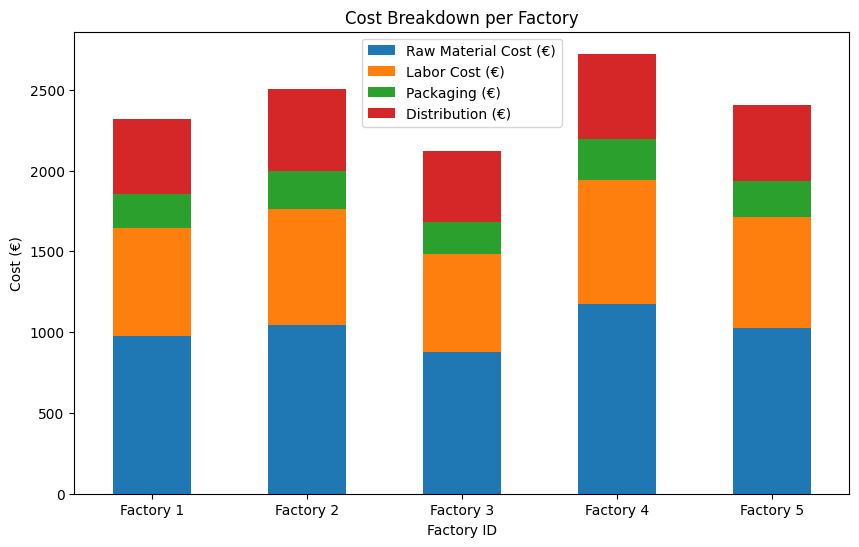

/tmp/ipython-input-4029630438.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=marketing_roi, x="Sales Channel", y="ROI", palette="viridis")


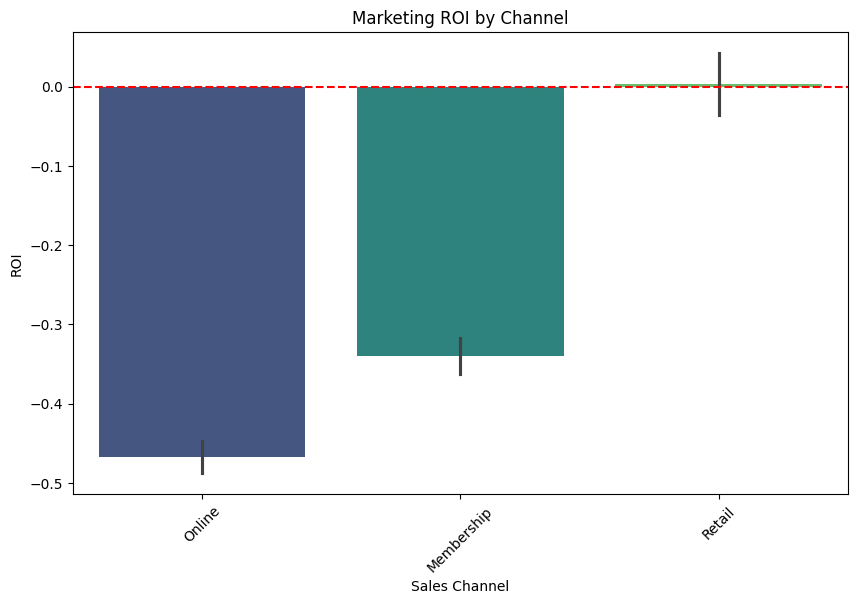

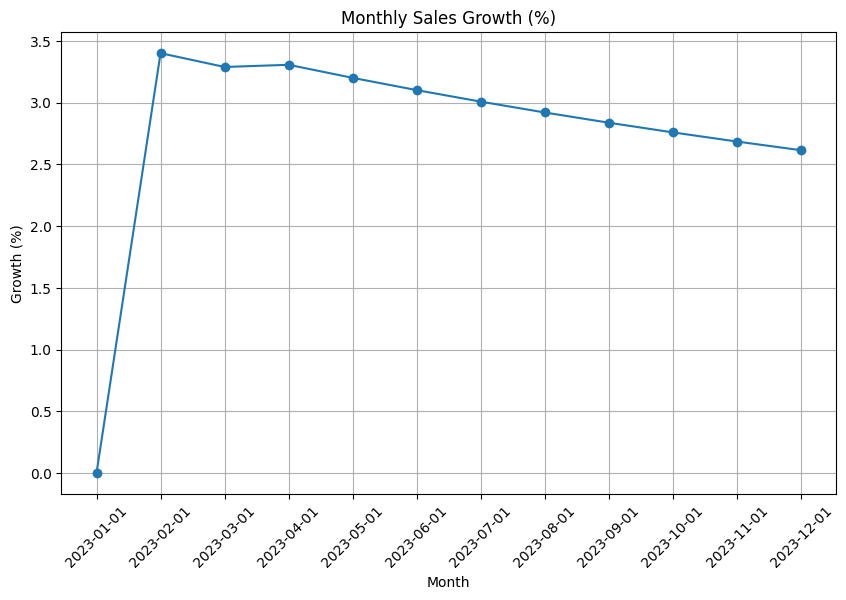

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Paths
IN_DIR = "/content/drive/MyDrive/Harrys/Data_Processed/KPI_File"

# Load existing KPI files
cost_breakdown = pd.read_csv(os.path.join(IN_DIR, "cost_breakdown_per_factory.csv"))
# Corrected file name for marketing ROI
marketing_roi = pd.read_csv(os.path.join(IN_DIR, "marketing_roi.csv"))
monthly_sales_growth = pd.read_csv(os.path.join(IN_DIR, "monthly_sales_growth.csv")) # Load monthly sales growth

# --- 1. Cost Breakdown per Factory ---
cost_breakdown.set_index("Factory ID")[["Raw Material Cost (€)", "Labor Cost (€)", "Packaging (€)", "Distribution (€)"]].plot(
    kind="bar", stacked=True, figsize=(10,6))
plt.title("Cost Breakdown per Factory")
plt.ylabel("Cost (€)")
plt.xticks(rotation=0)
plt.show()

# --- 2. Marketing ROI ---
print("Columns in marketing_roi before plotting:", marketing_roi.columns) # Debug print
# Ensure "Sales Channel" and "ROI" columns exist before plotting
if "Sales Channel" in marketing_roi.columns and "ROI" in marketing_roi.columns:
    plt.figure(figsize=(10,6))
    sns.barplot(data=marketing_roi, x="Sales Channel", y="ROI", palette="viridis")
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Marketing ROI by Channel")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Sales Channel or ROI column not found in marketing ROI data for plotting.")


# --- 3. Monthly Sales Growth ---
# Ensure "Month" and "Growth (%)" columns exist before plotting
if "Month" in monthly_sales_growth.columns and "Growth (%)" in monthly_sales_growth.columns:
    monthly_sales_growth["Month"] = pd.to_datetime(monthly_sales_growth["Month"]).astype(str)
    plt.figure(figsize=(10,6))
    plt.plot(monthly_sales_growth["Month"], monthly_sales_growth["Growth (%)"], marker="o")
    plt.title("Monthly Sales Growth (%)")
    plt.xlabel("Month")
    plt.ylabel("Growth (%)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
else:
    print("Month or Growth (%) column not found in monthly sales growth data for plotting.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p "/content/drive/MyDrive/Harrys/Visuals"

# Example saving
plt.savefig("/content/drive/MyDrive/Harrys/Visuals/cost_breakdown.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

KeyError: 'Factory'

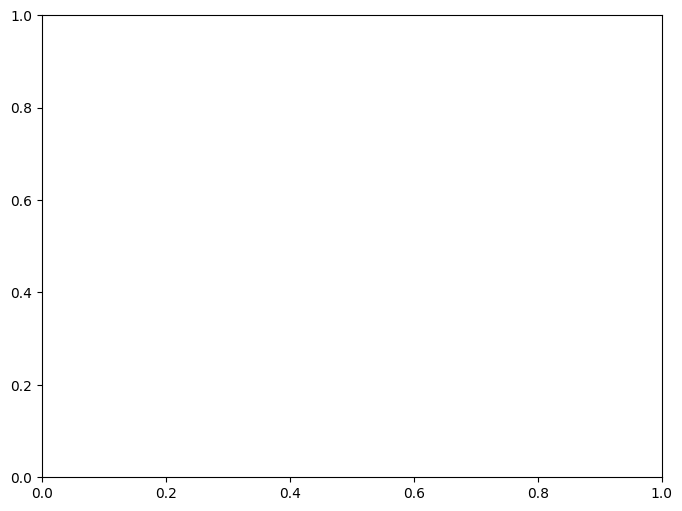

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Example: Cost breakdown data
cost_breakdown = pd.read_csv("/content/drive/MyDrive/Harrys/Data_Processed/KPI_File/cost_breakdown_per_factory.csv")

# Create figure
plt.figure(figsize=(8,6))

# Plot
cost_breakdown.plot(kind="bar", x="Factory", stacked=True, ax=plt.gca())

# Add labels & title
plt.title("Cost Breakdown per Factory")
plt.xlabel("Factory")
plt.ylabel("Cost (€)")
plt.legend(title="Cost Type")

# Save to Drive
plt.savefig("/content/drive/MyDrive/Harrys/Visuals/cost_breakdown.png", dpi=300, bbox_inches="tight")

# Also show in notebook
plt.show()


In [ ]:
import pandas as pd

cost_breakdown = pd.read_csv("/content/drive/MyDrive/Harrys/Data_Processed/KPI_File/cost_breakdown_per_factory.csv")
print(cost_breakdown.columns)


Index(['Factory ID', 'Raw Material Cost (€)', 'Labor Cost (€)',
       'Packaging (€)', 'Distribution (€)', 'Total Cost (€)'],
      dtype='object')


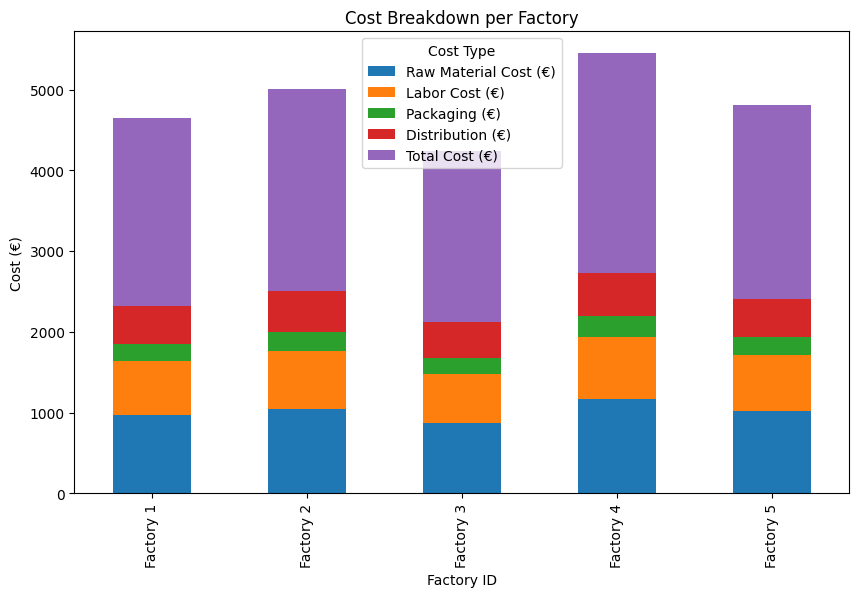

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
cost_breakdown.plot(
    kind="bar",
    x="Factory ID",   # ✅ correct column
    stacked=True,
    ax=plt.gca()
)

plt.title("Cost Breakdown per Factory")
plt.xlabel("Factory ID")
plt.ylabel("Cost (€)")
plt.legend(title="Cost Type")

plt.savefig("/content/drive/MyDrive/Harrys/Visuals/cost_breakdown.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd

cost_breakdown = pd.read_csv("/content/drive/MyDrive/Harrys/Data_Processed/KPI_File/cost_breakdown_per_factory.csv")
print(cost_breakdown.columns)


Index(['Factory ID', 'Raw Material Cost (€)', 'Labor Cost (€)',
       'Packaging (€)', 'Distribution (€)', 'Total Cost (€)'],
      dtype='object')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

sales = pd.read_csv("/content/drive/MyDrive/Harrys/Data_Processed/Clean_File/sales_data_clean.csv")
print(sales.columns)
sales.head()


Index(['Month', 'Region', 'Sales Channel', 'Product Type', 'Units Sold',
       'Revenue (€)'],
      dtype='object')


,Month,Region,Sales Channel,Product Type,Units Sold,Revenue (€)
0,2023-01-01,Paris,Online,White,1800,9000
1,2023-01-01,Paris,Online,Brown,1500,7500
2,2023-01-01,Paris,Online,Multigrain,1200,6000
3,2023-01-01,Paris,Membership,White,2200,11000
4,2023-01-01,Paris,Membership,Brown,1900,9500


from matplotlib import pyplot as plt
_df_0['Units Sold'].plot(kind='hist', bins=20, title='Units Sold')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Revenue (€)'].plot(kind='hist', bins=20, title='Revenue (€)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Sales Channel').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Product Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Units Sold', y='Revenue (€)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Units Sold'].plot(kind='line', figsize=(8, 4), title='Units Sold')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Revenue (€)'].plot(kind='line', figsize=(8, 4), title='Revenue (€)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Product Type'].value_counts()
    for x_label, grp in _df_7.groupby('Sales Channel')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Sales Channel')
_ = plt.ylabel('Product Type')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['Sales Channel'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='Units Sold', y='Sales Channel', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['Product Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='Units Sold', y='Product Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['Sales Channel'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='Revenue (€)', y='Sales Channel', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['Product Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='Revenue (€)', y='Product Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Ensure Month column is datetime
sales["Month"] = pd.to_datetime(sales["Month"], errors="coerce")

# Group revenue by month
monthly_sales = sales.groupby(sales["Month"].dt.to_period("M"))["Revenue"].sum().reset_index()
monthly_sales["Month"] = monthly_sales["Month"].astype(str)

# Plot
plt.figure(figsize=(10,6))
plt.plot(monthly_sales["Month"], monthly_sales["Revenue"], marker="o", color="blue")
plt.title("Monthly Revenue Growth")
plt.xlabel("Month")
plt.ylabel("Total Revenue (€)")
plt.xticks(rotation=45)
plt.grid(True)

# Save chart
plt.savefig(os.path.join(VISUALS_DIR, "sales_growth.png"), dpi=300, bbox_inches="tight")
plt.show()

# (Optional) Save data as CSV
monthly_sales.to_csv("/content/drive/MyDrive/Harrys/Data_Processed/KPI_File/monthly_sales_growth.csv", index=False)


KeyError: 'Column not found: Revenue'

In [ ]:
print(sales.columns)   # show column names
print(sales.head())    # show first 5 rows


Index(['Month', 'Region', 'Sales Channel', 'Product Type', 'Units Sold',
       'Revenue (€)'],
      dtype='object')
       Month Region Sales Channel Product Type  Units Sold  Revenue (€)
0 2023-01-01  Paris        Online        White        1800         9000
1 2023-01-01  Paris        Online        Brown        1500         7500
2 2023-01-01  Paris        Online   Multigrain        1200         6000
3 2023-01-01  Paris    Membership        White        2200        11000
4 2023-01-01  Paris    Membership        Brown        1900         9500


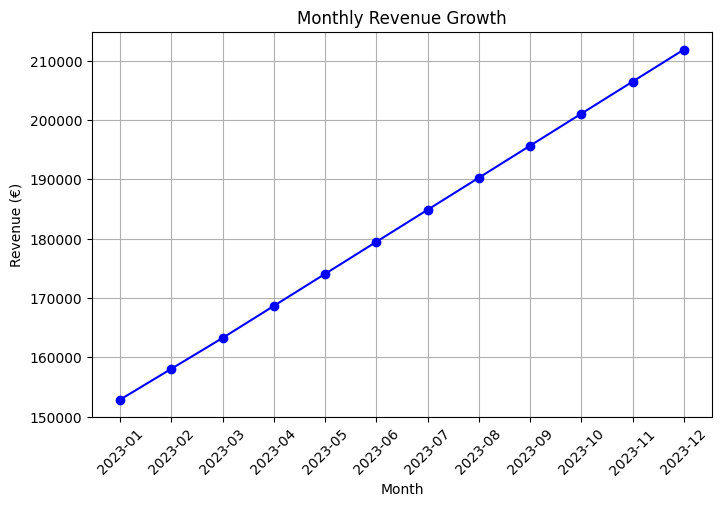

In [ ]:
import matplotlib.pyplot as plt
import os

# Ensure Month is datetime
sales["Month"] = pd.to_datetime(sales["Month"])

# Group revenue by month
monthly_sales = sales.groupby(sales["Month"].dt.to_period("M"))["Revenue (€)"].sum().reset_index()
monthly_sales["Month"] = monthly_sales["Month"].astype(str)

# Plot
plt.figure(figsize=(8,5))
plt.plot(monthly_sales["Month"], monthly_sales["Revenue (€)"], marker="o", color="blue")
plt.title("Monthly Revenue Growth")
plt.xlabel("Month")
plt.ylabel("Revenue (€)")
plt.xticks(rotation=45)
plt.grid(True)

# Save to visuals
plt.savefig(os.path.join(VISUALS_DIR, "sales_growth.png"), dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import os

# List files in Clean_File
print("Files in Clean_File folder:")
print(os.listdir(CLEAN_DIR))


Files in Clean_File folder:
['costing_data_clean.csv', 'sales_data_clean.csv', 'marketing_data_clean.csv']


In [ ]:
# Load correct marketing file
marketing_path = os.path.join(CLEAN_DIR, "marketing_data_clean.csv")
marketing = pd.read_csv(marketing_path)

print("Columns in marketing data:")
print(marketing.columns)
marketing.head()


Columns in marketing data:
Index(['Month', 'Region', 'Channel', 'Marketing Spend (€)',
       'Competitor Sales Jacquet (€)', 'Competitor Sales La Boulangère (€)'],
      dtype='object')


,Month,Region,Channel,Marketing Spend (€),Competitor Sales Jacquet (€),Competitor Sales La Boulangère (€)
0,2023-01-01,Paris,Online,12000,55000,45000
1,2023-01-01,Paris,Membership,15000,60000,50000
2,2023-01-01,Paris,Retail,20000,85000,70000
3,2023-01-01,South France,Online,8000,35000,30000
4,2023-01-01,South France,Membership,10000,40000,35000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os

BASE_DIR = "/content/drive/MyDrive/Harrys"
print("Files & folders in Harrys project:")
print(os.listdir(BASE_DIR))


Files & folders in Harrys project:
['Copy of Untitled2.ipynb', '.venv', 'dashboard', 'Data_Raw', 'Notebooks', 'making data', 'scripts', 'temp', 'Reports', 'Visuals', 'Data_Processed']


In [ ]:
# List inside Data_Processed
processed_dir = os.path.join(BASE_DIR, "Data_Processed")
print("Folders & files in Data_Processed:")
print(os.listdir(processed_dir))


Folders & files in Data_Processed:
['New folder', 'Clean_File', 'KPI_File']


In [ ]:
clean_dir = os.path.join(processed_dir, "Clean_File")
print("Files in Clean_File:")
print(os.listdir(clean_dir))


Files in Clean_File:
['costing_data_clean.csv', 'sales_data_clean.csv', 'marketing_data_clean.csv']


In [ ]:
import pandas as pd

# Path to marketing data
marketing_path = os.path.join(clean_dir, "marketing_data_clean.csv")
marketing = pd.read_csv(marketing_path)

print("Columns in marketing data:")
print(marketing.columns)
marketing.head()


Columns in marketing data:
Index(['Month', 'Region', 'Channel', 'Marketing Spend (€)',
       'Competitor Sales Jacquet (€)', 'Competitor Sales La Boulangère (€)'],
      dtype='object')


,Month,Region,Channel,Marketing Spend (€),Competitor Sales Jacquet (€),Competitor Sales La Boulangère (€)
0,2023-01-01,Paris,Online,12000,55000,45000
1,2023-01-01,Paris,Membership,15000,60000,50000
2,2023-01-01,Paris,Retail,20000,85000,70000
3,2023-01-01,South France,Online,8000,35000,30000
4,2023-01-01,South France,Membership,10000,40000,35000


NameError: name 'VISUALS_DIR' is not defined

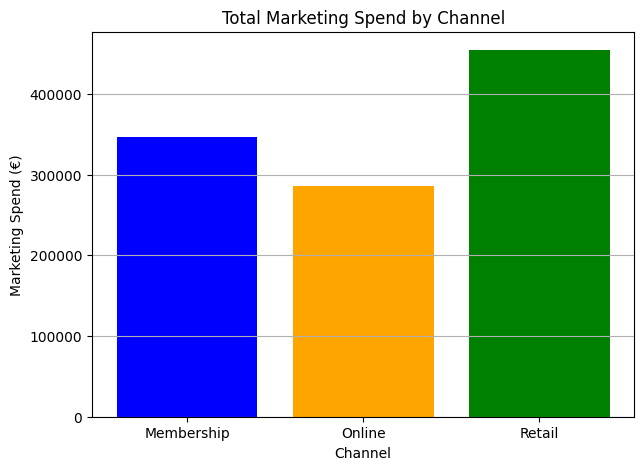

In [ ]:
import matplotlib.pyplot as plt

# Group by channel
channel_spend = marketing.groupby("Channel")["Marketing Spend (€)"].sum().reset_index()

# Plot
plt.figure(figsize=(7,5))
plt.bar(channel_spend["Channel"], channel_spend["Marketing Spend (€)"], color=["blue","orange","green"])
plt.title("Total Marketing Spend by Channel")
plt.xlabel("Channel")
plt.ylabel("Marketing Spend (€)")
plt.grid(axis="y")

# Save chart
plt.savefig(os.path.join(VISUALS_DIR, "marketing_roi.png"), dpi=300, bbox_inches="tight")
plt.show()


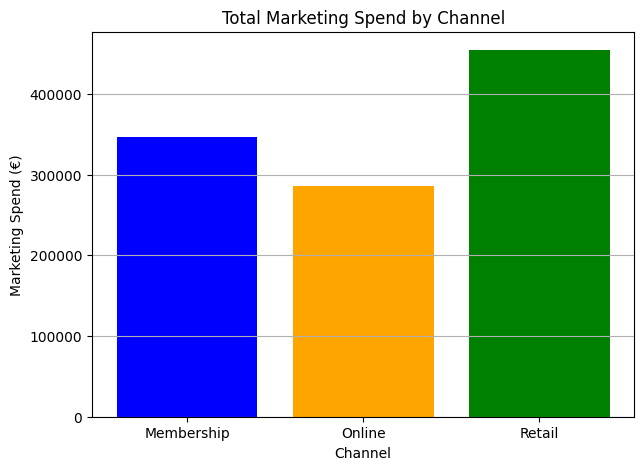

In [ ]:
import matplotlib.pyplot as plt

# Group by channel
channel_spend = marketing.groupby("Channel")["Marketing Spend (€)"].sum().reset_index()

# Plot
plt.figure(figsize=(7,5))
plt.bar(channel_spend["Channel"], channel_spend["Marketing Spend (€)"], color=["blue","orange","green"])
plt.title("Total Marketing Spend by Channel")
plt.xlabel("Channel")
plt.ylabel("Marketing Spend (€)")
plt.grid(axis="y")

# Save chart
plt.savefig(os.path.join(VISUALS_DIR, "marketing_roi.png"), dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Define Visuals directory
VISUALS_DIR = os.path.join(BASE_DIR, "Visuals")

# Create it if it doesn't exist
os.makedirs(VISUALS_DIR, exist_ok=True)

print("Visuals will be saved in:", VISUALS_DIR)


Visuals will be saved in: /content/drive/MyDrive/Harrys/Visuals


In [ ]:
# Define Visuals directory
VISUALS_DIR = os.path.join(BASE_DIR, "Visuals")

# Create it if it doesn't exist
os.makedirs(VISUALS_DIR, exist_ok=True)

print("Visuals will be saved in:", VISUALS_DIR)



Visuals will be saved in: /content/drive/MyDrive/Harrys/Visuals


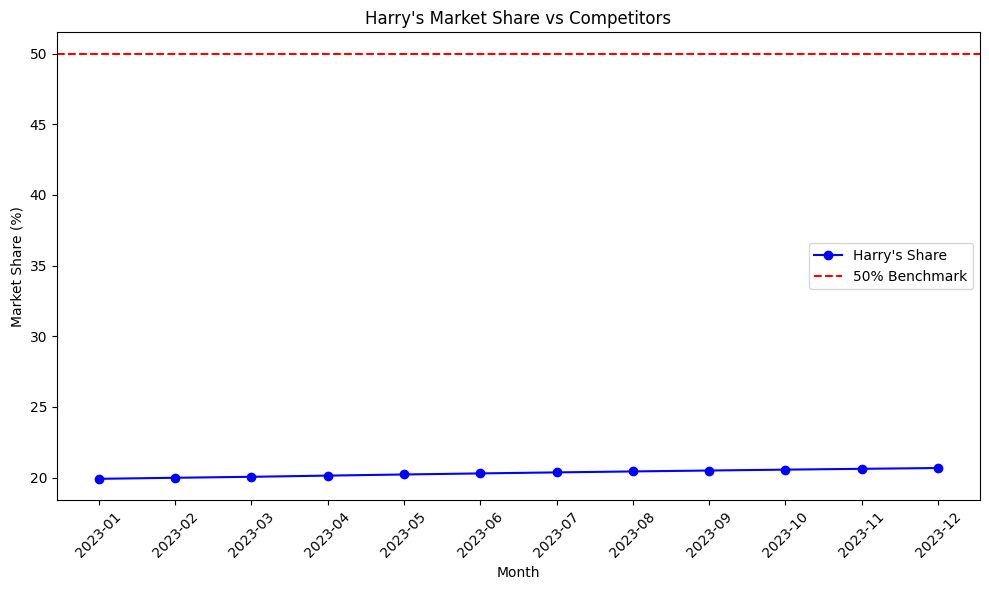

✅ Market Share chart saved in: /content/drive/MyDrive/Harrys/Visuals


In [ ]:
# === Market Share vs Competitors ===
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load sales and marketing data
sales = pd.read_csv(os.path.join(CLEAN_DIR, "sales_data_clean.csv"))
marketing = pd.read_csv(os.path.join(CLEAN_DIR, "marketing_data_clean.csv"))

# Ensure Month column is datetime
sales["Month"] = pd.to_datetime(sales["Month"])
marketing["Month"] = pd.to_datetime(marketing["Month"])

# Aggregate Harry’s revenue per month
harrys_sales = sales.groupby(sales["Month"].dt.to_period("M"))["Revenue (€)"].sum().reset_index()
harrys_sales["Month"] = harrys_sales["Month"].astype(str)

# Aggregate competitors’ sales per month
competitors = marketing.groupby(marketing["Month"].dt.to_period("M"))[
    ["Competitor Sales Jacquet (€)", "Competitor Sales La Boulangère (€)"]
].sum().reset_index()
competitors["Month"] = competitors["Month"].astype(str)

# Merge Harry’s sales with competitor sales
market_share = pd.merge(harrys_sales, competitors, on="Month", how="inner")

# Compute market share %
market_share["Total Market"] = (
    market_share["Revenue (€)"] +
    market_share["Competitor Sales Jacquet (€)"] +
    market_share["Competitor Sales La Boulangère (€)"]
)
market_share["Harrys Share (%)"] = (market_share["Revenue (€)"] / market_share["Total Market"]) * 100

# Plot
plt.figure(figsize=(10,6))
plt.plot(market_share["Month"], market_share["Harrys Share (%)"], marker="o", color="blue", label="Harry's Share")
plt.axhline(50, color="red", linestyle="--", label="50% Benchmark")
plt.title("Harry's Market Share vs Competitors")
plt.xlabel("Month")
plt.ylabel("Market Share (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Save chart
plt.savefig(os.path.join(VISUALS_DIR, "market_share.png"), dpi=300, bbox_inches="tight")
plt.show()

print("✅ Market Share chart saved in:", VISUALS_DIR)
